In [2]:
#!pip install tweepy
#!pip install --upgrade watson-developer-cloud

# Personality Insights

https://console.bluemix.net/docs/services/personality-insights/models.html#models

## Librerias

In [3]:
import re
import tweepy
import json
import pprint
import math
from tweepy import OAuthHandler
from watson_developer_cloud import PersonalityInsightsV3
import pandas as pd
from functools import reduce
#from textblob import TextBlob

## Extraccion de tweets

Usaremos los tweets para formar el corpus de prueba que enviaremos al API.

In [4]:
#coloque aqui Credenciales Twitter

In [5]:
# The code was removed by DSX for sharing.

In [6]:
class TwitterClient(object):
    '''
    Generic Twitter Class for sentiment analysis.
    '''
    def __init__(self):
        '''
        Class constructor or initialization method.
        '''
        # attempt authentication
        try:
            # create OAuthHandler object
            self.auth = OAuthHandler(consumer_key, consumer_secret)
            # set access token and secret
            self.auth.set_access_token(access_token, access_token_secret)
            # create tweepy API object to fetch tweets
            self.api = tweepy.API(self.auth)
        except:
            print("Error: Authentication Failed")
 
    def clean_tweet(self, tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())  
    
    def parse_tweets(self, fetched_tweets):
        tweets = []
        
        for tweet in fetched_tweets:
                # empty dictionary to store required params of a tweet
                parsed_tweet = {}
 
                # saving text of tweet
                parsed_tweet['content'] = tweet.text
                #parsed_tweet['clean_text'] = self.clean_tweet(tweet.text)
                parsed_tweet['contenttype'] = 'text/plain' 
                parsed_tweet['language'] = tweet.lang
                parsed_tweet['id'] = tweet.id_str
                parsed_tweet['created'] = math.floor(tweet.created_at.timestamp())
                
                #parsed_tweet = tweet
                
                # appending parsed tweet to tweets list
                if tweet.retweet_count > 0:
                    # if tweet has retweets, ensure that it is appended only once
                    if parsed_tweet not in tweets:
                        tweets.append(parsed_tweet)
                else:
                    tweets.append(parsed_tweet)
                    
        return tweets
        
    def get_raw_tweets(self,query,count=10):        
        try:
            # call twitter api to fetch tweets
            fetched_tweets = self.api.search(q = query, count = count)
 
            # parsing tweets one by one
            tweets = self.parse_tweets(fetched_tweets)
 
            # return parsed tweets
            return tweets
 
        except tweepy.TweepError as e:
            # print error (if any)
            print("Error : " + str(e))
            
    def get_user_tweets(self, userid, count):
        tweets=[]
        
        try:
            # call twitter api to fetch tweets
            fetched_tweets = self.api.user_timeline(id=userid,count=200)
 
            # parsing tweets one by one
            tweets = self.parse_tweets(fetched_tweets)
            return tweets
 
        except tweepy.TweepError as e:
            # print error (if any)
            print("Error : " + str(e))

Teniendo los metodos, podemos extraer los tweets para un id de usuario particular

In [7]:
# creating object of TwitterClient ClassBogota
api = TwitterClient()
# calling function to get tweets
tweets = api.get_user_tweets('carlosvives',count=1000)

tweets[1:3] #mostramos los primeros 3

[{'content': 'RT @traslaperla: Inscríbete! Programa Impulso es un programa de la organización UWC, que convoca a 40 jóvenes colombianos de varias regione…',
  'contenttype': 'text/plain',
  'created': 1520547576,
  'id': '971782494222802946',
  'language': 'es'},
 {'content': 'RT @Tigo_Bolivia: Llénate de energía y optimismo 😊 🎶 con el colorido video de @carlosvives y @MelendiOficial #ElArrepentido 🎧 \nEntra a http…',
  'contenttype': 'text/plain',
  'created': 1520526993,
  'id': '971696162737655808',
  'language': 'es'}]

Debemos poner los tweet en un formato especifico para enviarlos a watson

In [8]:
body = {"contentItems" : tweets}

## Calculamos el perfil

Ahora que tenemos los tweet procesados, podemos usar la API de Personality Insights. Primero creamos el objeto que permite enviar peticiones.

In [9]:
#coloque aqui Credenciales NLU

In [10]:
# The code was removed by DSX for sharing.

In [11]:
personality_insights = PersonalityInsightsV3(
    version='2016-10-20',
    username = nlu_username,
password = nlu_password)

La funcion `profile` devuelve el perfil en formato json

In [12]:
profile = personality_insights.profile(
    body, 
    content_type='application/json',
    accept_language = 'es')

In [13]:
pp = pprint.PrettyPrinter(indent=4)

In [14]:
pp.pprint(profile)

{   'behavior': [   {   'category': 'behavior',
                        'name': 'Domingo',
                        'percentage': 1.0,
                        'trait_id': 'behavior_sunday'},
                    {   'category': 'behavior',
                        'name': 'Lunes',
                        'percentage': 0.0,
                        'trait_id': 'behavior_monday'},
                    {   'category': 'behavior',
                        'name': 'Martes',
                        'percentage': 0.0,
                        'trait_id': 'behavior_tuesday'},
                    {   'category': 'behavior',
                        'name': 'Miércoles',
                        'percentage': 0.0,
                        'trait_id': 'behavior_wednesday'},
                    {   'category': 'behavior',
                        'name': 'Jueves',
                        'percentage': 0.0,
                        'trait_id': 'behavior_thursday'},
                    {   'category': 'behavior'

Encontramos
* Necesidades (needs)
* Personalidad (personality). Calculada como el Big5
* Valores
* Tendencias de consumo

## Como Interpretar los score?

## Que hacer con el perfil?

Graficas por supuesto

In [15]:
big5 = pd.DataFrame(list(map( lambda x: {'percentil':x['percentile'], 'nombre': x['name']}, profile['personality'])))
values = pd.DataFrame(list(map( lambda x: {'percentil':x['percentile'], 'nombre': x['name']}, profile['values'])))
needs = pd.DataFrame(list(map( lambda x: {'percentil':x['percentile'], 'nombre': x['name']}, profile['needs'])))

In [16]:
big5.sort_values('percentil', ascending = False)

,nombre,percentil
3,Amabilidad,0.995154
1,Responsabilidad,0.981383
0,Apertura a experiencias,0.981187
2,Extroversión,0.826490
4,Rango emocional,0.536470


In [17]:
values

,nombre,percentil
0,Conservación,0.964407
1,Apertura al cambio,0.467350
2,Hedonismo,0.218782
3,Superación personal,0.113574
4,Autotranscendencia,0.367261


In [18]:
needs

,nombre,percentil
0,Desafío,0.544392
1,Familiaridad,0.939634
2,Curiosidad,0.230437
3,Entusiasmo,0.387978
4,Armonía,0.885195
5,Ideal,0.089044
6,Libertad,0.717940
7,Amor,0.555348
8,Practicidad,0.636475
9,Autoexpresión,0.012393


Podemos usar estas features para aumentar modelos convencionales de machine learning

In [19]:
big5['user'] = 'carlosvives'
big5 = big5.pivot(index='user', columns='nombre', values='percentil')

In [20]:
big5

nombre,Amabilidad,Apertura a experiencias,Extroversión,Rango emocional,Responsabilidad
user,,,,,
carlosvives,0.995154,0.981187,0.82649,0.53647,0.981383


Escalemos esto a mas usuarios

In [21]:
def get_profile(user):
    print(user)
    tweets = api.get_user_tweets(user, count=1000)
    body = {"contentItems" : tweets}
    profile = personality_insights.profile(
        body, 
        content_type='application/json',
        accept_language = 'es')
    
    profile['user'] = user
    
    return profile

#aspect puede ser personality, needs, values
def aspect_table(profile, aspect):
    data = pd.DataFrame(list(map( lambda x: {'percentil':x['percentile'], 'nombre': x['name']}, profile[aspect])))
    data['user'] = profile['user']
    return data

def all_aspects_table(profile):
    big5 = aspect_table(profile, 'personality')
    values = aspect_table(profile, 'values')
    needs = aspect_table(profile, 'needs')
    
    all_aspects = big5.append(values, ignore_index=True)
    all_aspects = all_aspects.append(needs, ignore_index=True)
    
    return all_aspects

In [22]:
usuarios = ['jamesdrodriguez', 'FALCAO', 'juanes', 'SofiaVergara', 'JBALVIN', 'carlosvives', 'jessicacediel', 'LAAZCARATE', 'susoelpaspi', 'Cuadrado','lopezandres','ninagarcia','Soymarioruiz','D_Ospina1','CaroCruzO','juanjaramilloe','PLinero','SilvestreFDC','DanielSamperO','PirryTv','cejaspobladas','marianapajon']

In [23]:
perfiles = list(map(get_profile, usuarios))

jamesdrodriguez
FALCAO
juanes
SofiaVergara
JBALVIN
carlosvives
jessicacediel
LAAZCARATE
susoelpaspi
Cuadrado
lopezandres
ninagarcia
Soymarioruiz
D_Ospina1
CaroCruzO
juanjaramilloe
PLinero
SilvestreFDC
DanielSamperO
PirryTv
cejaspobladas
marianapajon


In [24]:
tablas_aspectos = list(map(all_aspects_table, perfiles))

In [25]:
tablas_aspectos[3]

,nombre,percentil,user
0,Apertura a experiencias,0.355726,SofiaVergara
1,Responsabilidad,0.880040,SofiaVergara
2,Extroversión,0.671151,SofiaVergara
3,Amabilidad,0.938145,SofiaVergara
4,Rango emocional,0.412475,SofiaVergara
5,Conservación,0.954362,SofiaVergara
6,Apertura al cambio,0.591331,SofiaVergara
7,Hedonismo,0.690690,SofiaVergara
8,Superación personal,0.871115,SofiaVergara
9,Autotranscendencia,0.712553,SofiaVergara


In [26]:
aspectos_juntos = reduce(lambda acc, user_table: acc.append(user_table, ignore_index=True), tablas_aspectos)

In [54]:
data_for_model = aspectos_juntos.pivot(index='user', columns='nombre', values='percentil').reset_index()
data_for_model.head()

nombre,user,Amabilidad,Amor,Apertura a experiencias,Apertura al cambio,Armonía,Autoexpresión,Autotranscendencia,Conservación,Curiosidad,...,Estructura,Extroversión,Familiaridad,Hedonismo,Ideal,Libertad,Practicidad,Rango emocional,Responsabilidad,Superación personal
0,CaroCruzO,0.646199,0.600030,0.476340,0.384629,0.815470,0.315014,0.636343,0.966581,0.876685,...,0.910267,0.302479,0.875006,0.562297,0.552993,0.325503,0.695605,0.632731,0.664874,0.817373
1,Cuadrado,0.995925,0.181823,0.978906,0.075634,0.232982,0.112928,0.733983,0.943744,0.162484,...,0.247685,0.604222,0.414035,0.220988,0.219244,0.243811,0.641920,0.186415,0.971403,0.033411
2,D_Ospina1,0.933331,0.181435,0.896155,0.419867,0.706706,0.060610,0.690733,0.904115,0.382440,...,0.473320,0.453246,0.822147,0.187914,0.777369,0.417290,0.674567,0.586806,0.967340,0.394283
3,DanielSamperO,0.956985,0.385414,0.976401,0.550063,0.951305,0.138986,0.482195,0.617189,0.247907,...,0.451923,0.364495,0.755580,0.270216,0.095495,0.735233,0.708998,0.246838,0.620999,0.350755
4,FALCAO,0.875843,0.310915,0.663571,0.167764,0.716880,0.063734,0.291397,0.866418,0.140027,...,0.681902,0.562049,0.622512,0.202463,0.401236,0.238992,0.631271,0.483484,0.949751,0.073218


## Clustering

In [48]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

Z = linkage(data_for_model.drop("user", axis=1), "ward")

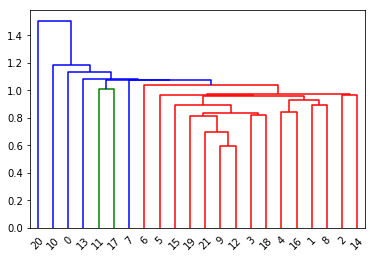

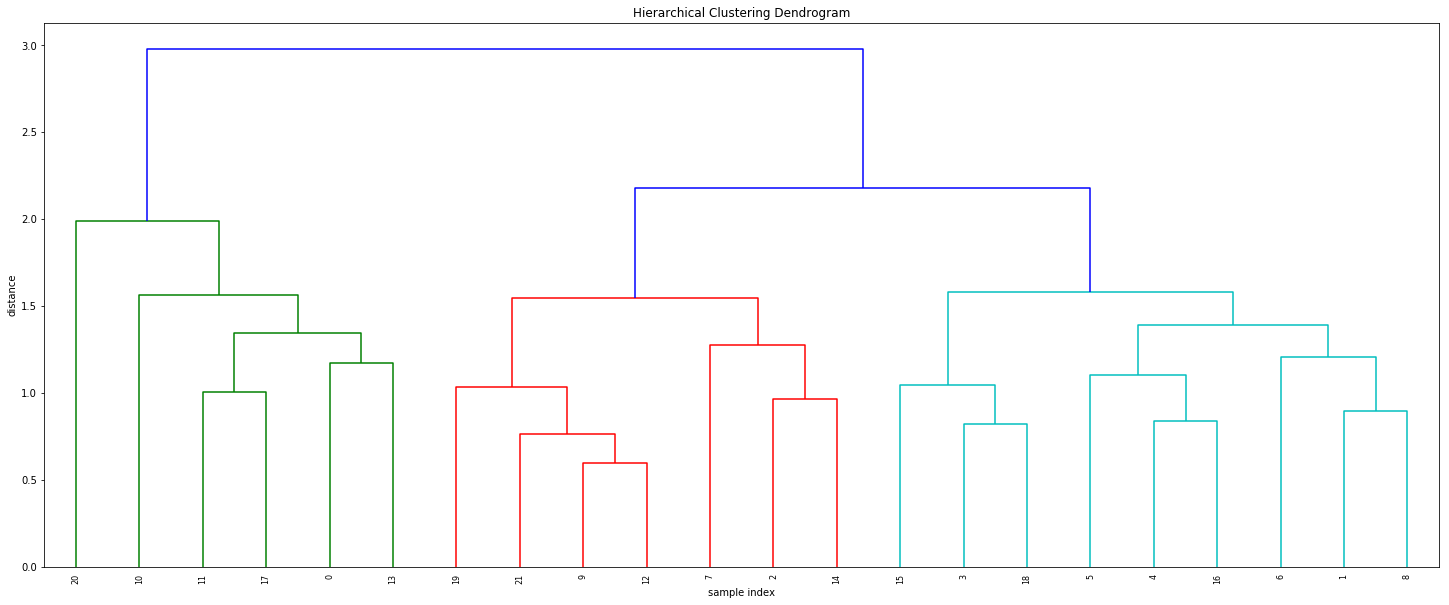

In [49]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

De acuerdo al diagrama, 2 parece ser un numero de clusters apropiado. Aunque en realidad los datos se encuentran muy separados entre si.

Para obtener asignaciones de cluster facilmente, reproducimos el anterior codigo usando scikit learn, el cual asigna una etiqueta de cluster para cada observacion. Aqui colocamos como parametro 2 o 4.

In [55]:
from sklearn.cluster import AgglomerativeClustering

In [56]:
cluster_mod = AgglomerativeClustering(n_clusters=4, linkage='ward')

In [57]:
clusters = cluster_mod.fit_predict(data_for_model.drop("user", axis=1))
clusters

array([1, 0, 2, 0, 0, 0, 0, 2, 0, 2, 1, 1, 2, 1, 2, 0, 0, 1, 0, 2, 3, 2])

In [59]:
resultados = pd.DataFrame({
    'user': data_for_model['user'],
    'cluster': clusters
})

resultados.sort_values('cluster')

,cluster,user
1,0,Cuadrado
18,0,lopezandres
3,0,DanielSamperO
4,0,FALCAO
5,0,JBALVIN
6,0,LAAZCARATE
8,0,PirryTv
16,0,juanes
15,0,jessicacediel
0,1,CaroCruzO


In [62]:
?linkage